In [2]:
import pandas as pd
import json
import os as os
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, zscore

In [3]:
def extract_power_dataframes_in_directory(directory):
    """
    Parcourt tous les fichiers JSON dans un répertoire donné, extrait les sous-JSON de la catégorie "power"
    et les enregistre en tant que fichiers CSV dans le même répertoire que les fichiers JSON originaux.
    
    :param directory: Chemin du répertoire contenant les fichiers JSON.
    """
    # Vérifier si le répertoire existe
    if not os.path.exists(directory):
        print(f"Le répertoire {directory} n'existe pas.")
        return

    # Parcourir tous les fichiers dans le répertoire
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            json_path = os.path.join(directory, filename)
            with open(json_path, 'r', encoding='utf-8') as f:
                data = json.load(f)

            # Récupérer les "counters"
            counters = data.get("counters", [])
            dataframes = []

            # Parcourir chaque sous-JSON dans "counters"
            for index, subjson in enumerate(counters):
                if subjson.get("category") == "power":
                    samples = subjson.pop('samples', None)
        
                    if samples:
                        time_samples = samples.get('time', [])
                        count_samples = samples.get('count', [])
        
                        if len(time_samples) == len(count_samples):
                            df = pd.DataFrame({
                                "time": time_samples,
                                "consumption": count_samples
                            })
                            df["name"] = subjson.get("name")
                            df["category"] = subjson.get("category")
                            df["description"] = subjson.get("description")
                            df["pid"] = subjson.get("pid")
                            df["mainThreadIndex"] = subjson.get("mainThreadIndex")
                            dataframes.append(df)  # Ajouter le DataFrame à la liste
    
                            # Sauvegarder chaque DataFrame en tant que fichier CSV dans le même répertoire
                            csv_filename = os.path.join(directory, f"{filename}_dataframe_{index+1}.csv")
                            df.to_csv(csv_filename, index=False)
                            print(f"DataFrame {index+1} extrait de {filename} et sauvegardé en tant que {csv_filename}")
                        else:
                            print(f"Les longueurs des échantillons de temps et de compte ne correspondent pas pour {subjson['name']} dans {filename}")


In [24]:
def combine_and_save_power_dataframes(directory):
    """
    Visualise les données des fichiers CSV contenant des données de la DRAM et du CPU dans un répertoire donné,
    calcule les moyennes pour chaque point de temps, les affiche sur une seule figure et enregistre la figure en tant que fichier PNG.
    
    :param directory: Chemin du répertoire contenant les fichiers CSV.
    """
    # Vérifier si le répertoire existe
    if not os.path.exists(directory):
        print(f"Le répertoire {directory} n'existe pas.")
        return

    cpu_dfs = []
    dram_dfs = []
    process_directory(directory)
    # Parcourir tous les fichiers dans le répertoire
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            
            csv_path = os.path.join(directory, filename)
            df = pd.read_csv(csv_path)

            if "CPU" in df["name"].iloc[0]:
                df.rename(columns={'consumption': 'CPU_Consumption'}, inplace=True)
                cpu_dfs.append(df)
            elif "DRAM" in df["name"].iloc[0]:
                df.rename(columns={'consumption': 'DRAM_Consumption'}, inplace=True)
                dram_dfs.append(df)

    if not cpu_dfs or not dram_dfs:
        print("Aucune donnée CPU ou DRAM trouvée dans les fichiers CSV.")
        return
    # Fusion des 10df de la conso cpu
    cpu_combined = pd.concat(cpu_dfs).sort_values(by="time")
    cpu_combined.drop(columns=['name','description'], inplace=True)
    csv_filename = os.path.join(directory, "cpu_combined.csv")
    cpu_combined.to_csv(csv_filename, index=False)
    print(cpu_combined.head())
     # Fusion des 10df de la conso dram
    dram_combined = pd.concat(dram_dfs).sort_values(by="time")
    dram_combined.drop(columns=['name','description'], inplace=True)
    csv_filename = os.path.join(directory, "dram_combined.csv")
    
    dram_combined.to_csv(csv_filename, index=False)
    #Merge de la dram et du cpu
    final_df = pd.DataFrame({
        "time": dram_combined['time'],
        "DRAM": dram_combined['DRAM_Consumption'],
        "CPU": cpu_combined['CPU_Consumption'],
        "Iteration" : dram_combined["itération"]
    })
    csv_filename = os.path.join(directory, "final_cpu_dram.csv")
    final_df.to_csv(csv_filename, index=False)

   

In [26]:
combine_and_save_power_dataframes('/Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit')

ON commence
          time  CPU_Consumption category    pid  mainThreadIndex  itération
0  3355.738840        169033474    power  82727                0         11
1  3365.737305        104997423    power  82727                0         11
2  3375.737222        104726155    power  82727                0         11
3  3385.734049         93231202    power  82727                0         11
4  3395.736022        104098849    power  82727                0         11


In [25]:
extract_power_dataframes_in_directory('/Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit')

DataFrame 2 extrait de Firefox 2024-06-11 11.21 profile.json et sauvegardé en tant que /Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/Firefox 2024-06-11 11.21 profile.json_dataframe_2.csv
DataFrame 3 extrait de Firefox 2024-06-11 11.21 profile.json et sauvegardé en tant que /Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/Firefox 2024-06-11 11.21 profile.json_dataframe_3.csv
DataFrame 1 extrait de Firefox 2024-06-11 11.26 profile.json et sauvegardé en tant que /Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/Firefox 2024-06-11 11.26 profile.json_dataframe_1.csv
DataFrame 2 extrait de Firefox 2024-06-11 11.26 profile.json et sauvegardé en tant que /Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/Firefox 2024-06-11 11.26 profile.json_dataframe_2.csv
DataFrame 1 extrait de Firefox 2024-06-11 11.32 profile.json et sauvegardé en tant que /Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/Firefox 2024-06-11 11.32

In [86]:
final_first = pd.read_csv('/Users/mtis/Local/Code/DataSphere/Practice/config10/first_visit/final_cpu_dram.csv')
final_second = pd.read_csv('/Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/final_cpu_dram.csv')

In [105]:
def delta_cpu_dram(path):
    # Charger les fichiers CSV des deux visites
    first_visit_df = pd.read_csv(path)
    # Calculer les moyennes de consommation CPU pour chaque visite
    first_visit_cpu_mean = first_visit_df['CPU'].dropna().mean()
    first_visit_dram_mean= first_visit_df['DRAM'].dropna().mean()
    
    # Préparer les données pour les box plots
    data_to_plot = [first_visit_df['CPU'], first_visit_df['DRAM']]
    
    # Création de la figure
    plt.figure(figsize=(10, 6))
    
    # Box plot
    plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=['CPU', 'DRAM'])
    
    # Titre et labels
    plt.title('Box Plots of Consumption')
    plt.ylabel('Consumption Value')
    
    fv_normalised = (first_visit_df['CPU'])
    sv_normalised = (first_visit_df['DRAM'])
    # Effectuer un test t de Student
    t_stat, p_value = ttest_ind(fv_normalised, sv_normalised, equal_var=False)
    
    # Afficher la p-value
    print(f"P-value: {p_value}")
    # Affichage
    plt.show()

P-value: 0.0


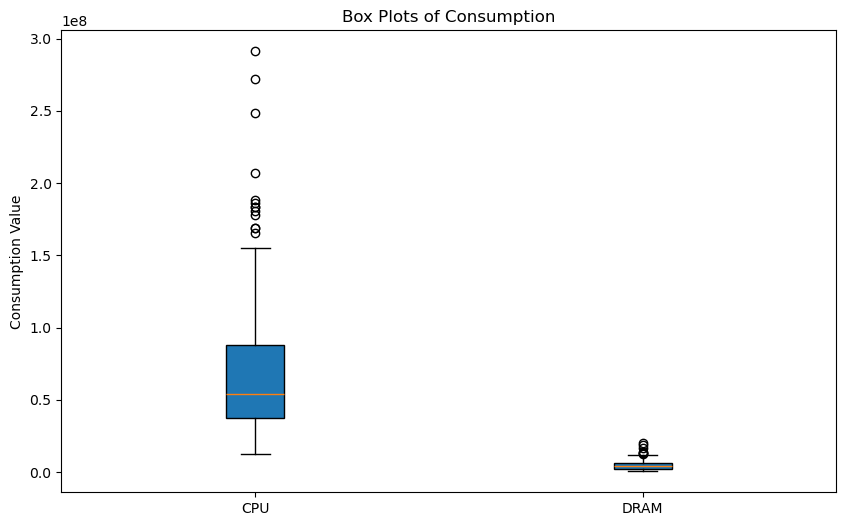

In [106]:
delta_cpu_dram('/Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/final_cpu_dram.csv')

In [111]:
def delta_cpu(path1,path2):
    # Charger les fichiers CSV des deux visites
    first_visit_cpu_df = pd.read_csv(path1)
    second_visit_cpu_df = pd.read_csv(path2)
    
    # Extraire les données de consommation CPU
    first_visit_cpu = first_visit_cpu_df['CPU'].dropna()
    second_visit_cpu = second_visit_cpu_df['CPU'].dropna()
    
    # Normaliser les données de consommation CPU en utilisant le Z-score
    first_visit_cpu_normalized = first_visit_cpu
    second_visit_cpu_normalized = second_visit_cpu
    
    # Calculer les moyennes des données normalisées
    first_visit_cpu_mean_normalized = first_visit_cpu_normalized.mean()
    second_visit_cpu_mean_normalized = second_visit_cpu_normalized.mean()
    
    print(first_visit_cpu_mean_normalized)
    print(second_visit_cpu_mean_normalized)
    
    # Effectuer un test t de Student sur les données normalisées
    t_stat, p_value = ttest_ind(first_visit_cpu_normalized, second_visit_cpu_normalized, equal_var=False)
    
    # Afficher la p-value
    print(f"P-value: {p_value}")
    
    # Préparer les données pour les box plots
    data_to_plot = [first_visit_cpu_normalized, second_visit_cpu_normalized]
    
    # Création de la figure
    plt.figure(figsize=(10, 6))
    
    # Box plot
    plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=['First Visit', 'Second Visit'])
    
    # Titre et labels
    plt.title('Box Plots of Normalized CPU Consumption')
    plt.ylabel('Normalized Consumption Value')
    
    # Affichage
    plt.show()


72968768.06422342
63821531.9381168
P-value: 1.1582018010550865e-247


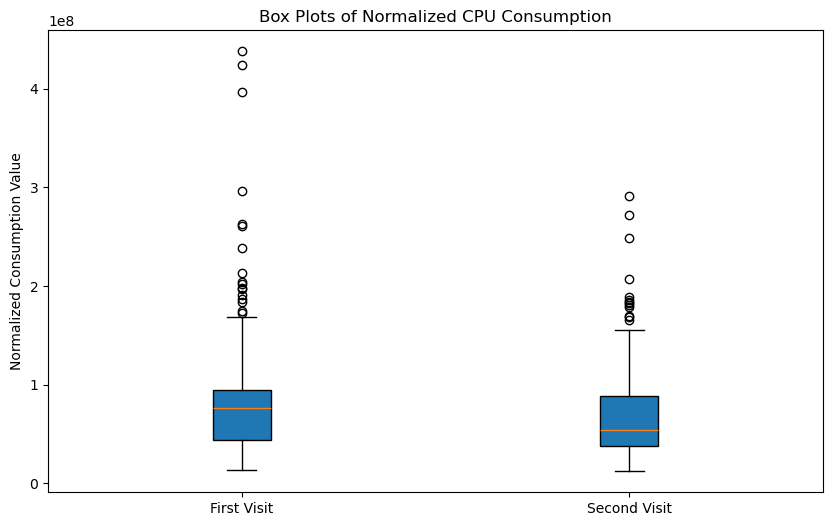

In [113]:
delta_cpu('/Users/mtis/Local/Code/DataSphere/Practice/config10/first_visit/final_cpu_dram.csv','/Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/final_cpu_dram.csv')

In [88]:
final_first['CPU'].mean()

72968768.06422342

In [89]:
final_second['CPU'].mean()

63821531.9381168

count    1.983700e+04
mean     4.898965e+06
std      2.042482e+06
min      5.255800e+05
25%      2.950033e+06
50%      5.552504e+06
75%      6.391737e+06
max      2.815246e+07
Name: DRAM, dtype: float64

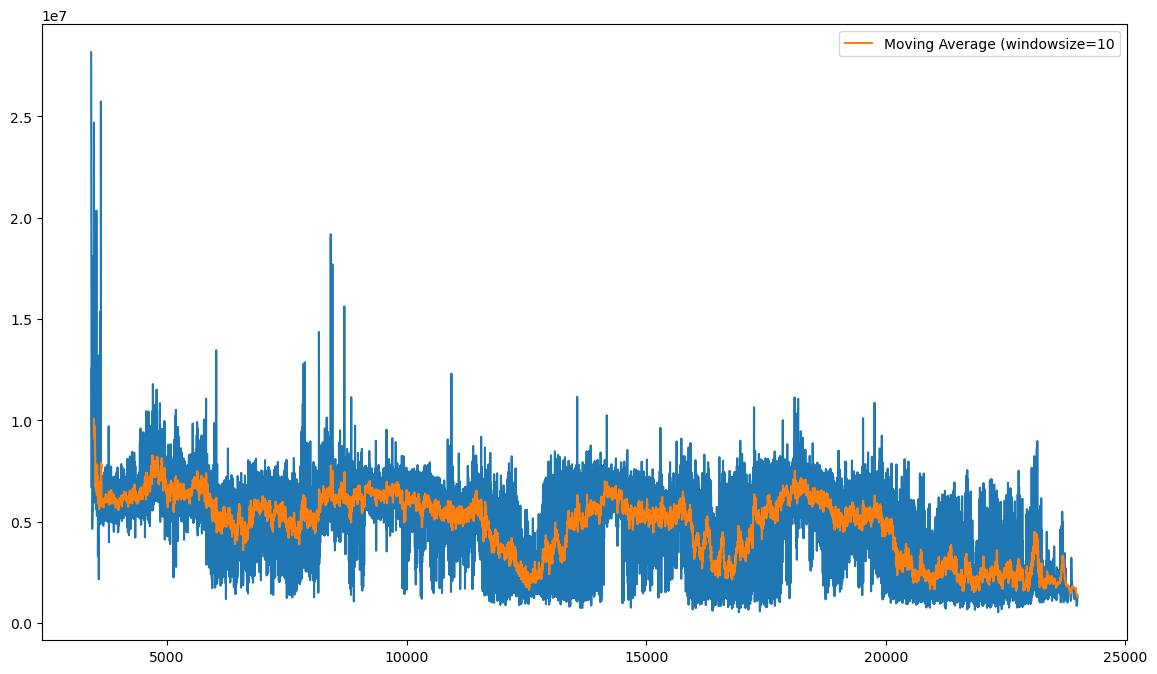

In [83]:
plt.figure(figsize=(14, 8))
window_sizes = [10]
for window_size in window_sizes:
    plt.plot(final_first['time'], final_first['DRAM'])
    final_first[f'consumption_ma_{window_size}'] = final_first['DRAM'].rolling(window=window_size).mean()
    plt.plot(final_first['time'], final_first[f'consumption_ma_{window_size}'], label=f'Moving Average (windowsize={window_size}')
    plt.legend()




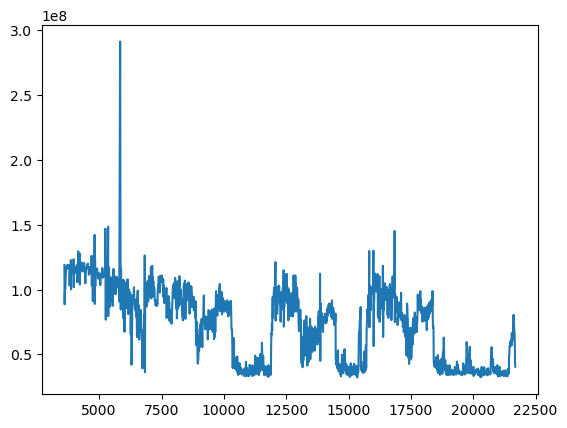

In [69]:
data = pd.read_csv('/Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/Firefox 2024-06-11 11.21 profile.json_dataframe_2.csv')
plt.plot(data['time'], data['consumption'])

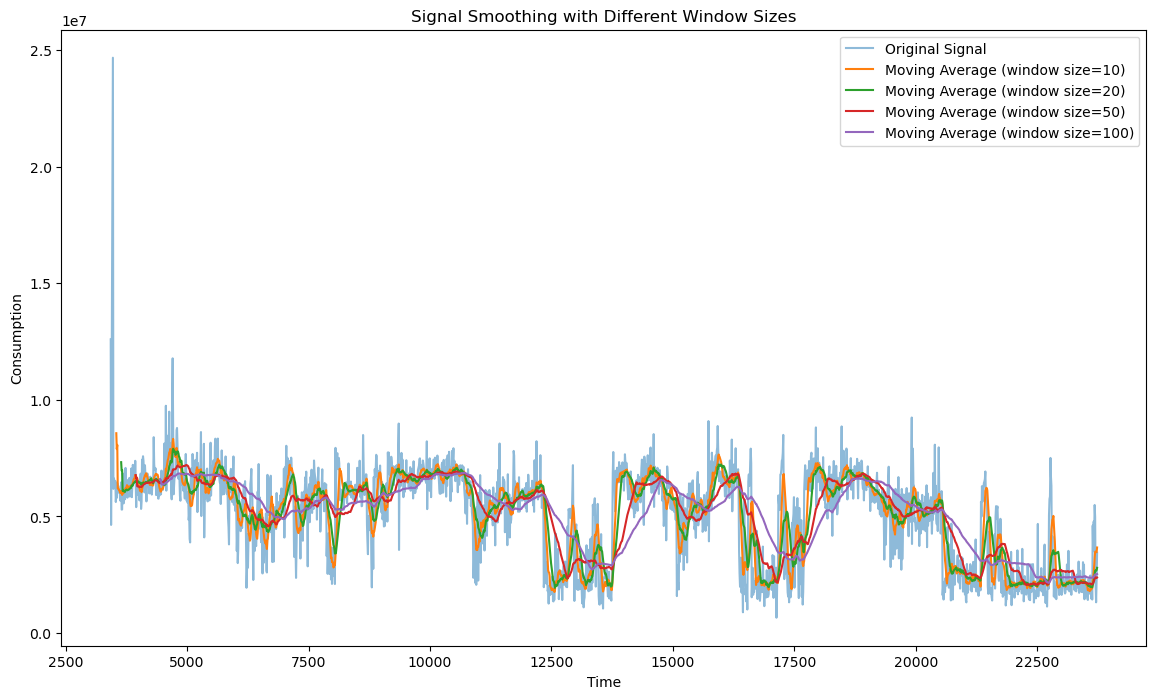

In [45]:
window_sizes = [10, 20, 50, 100]

plt.figure(figsize=(14, 8))

# Plot the original signal
plt.plot(data['time'], data['consumption'], label='Original Signal', alpha=0.5)

# Plot the smoothed signals with different window sizes
for window_size in window_sizes:
    data[f'consumption_ma_{window_size}'] = data['consumption'].rolling(window=window_size).mean()
    plt.plot(data['time'], data[f'consumption_ma_{window_size}'], label=f'Moving Average (window size={window_size})')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Signal Smoothing with Different Window Sizes')
plt.legend()
plt.show()

In [82]:
data1 = pd.read_csv('/Users/mtis/Local/Code/DataSphere/Practice/config10/first_visit/Firefox 2024-06-11 11.21 profile.json_dataframe_3.csv')
data2 = pd.read_csv('/Users/mtis/Local/Code/DataSphere/Practice/config10/first_visit/Firefox 2024-06-11 11.22 profile.json_dataframe_3.csv')
data3 = pd.read_csv('/Users/mtis/Local/Code/DataSphere/Practice/config10/first_visit/Firefox 2024-06-11 11.23 profile.json_dataframe_2.csv')
data4 = pd.read_csv('/Users/mtis/Local/Code/DataSphere/Practice/config10/first_visit/Firefox 2024-06-11 11.25 profile.json_dataframe_2.csv')
dram = data1
dram2 = pd.concat([data1, data2]).sort_values(by='time').reset_index(drop=True)
dram3 = pd.concat([data1, data2,data3]).sort_values(by='time').reset_index(drop=True)
dram4 = pd.concat([data1,data2,data3,data4]).sort_values(by='time').reset_index(drop=True)


In [67]:
data2

,time,consumption,name,category,description,pid,mainThreadIndex
0,3523.829735,20340813,Power: DRAM,power,Consumption of the dram domain,75817,0
1,3534.401653,5293952,Power: DRAM,power,Consumption of the dram domain,75817,0
2,3543.824786,6095039,Power: DRAM,power,Consumption of the dram domain,75817,0
3,3553.823925,6205241,Power: DRAM,power,Consumption of the dram domain,75817,0
4,3563.825211,6514655,Power: DRAM,power,Consumption of the dram domain,75817,0
...,...,...,...,...,...,...,...
1973,23253.870724,2263387,Power: DRAM,power,Consumption of the dram domain,75817,0
1974,23263.887279,2369351,Power: DRAM,power,Consumption of the dram domain,75817,0
1975,23273.879293,1792907,Power: DRAM,power,Consumption of the dram domain,75817,0
1976,23283.879136,2810161,Power: DRAM,power,Consumption of the dram domain,75817,0


In [68]:
dram

,time,consumption,name,category,description,pid,mainThreadIndex
0,3428.336293,12596978,Power: DRAM,power,Consumption of the dram domain,73894,0
1,3436.148107,4636976,Power: DRAM,power,Consumption of the dram domain,73894,0
2,3473.155098,24676853,Power: DRAM,power,Consumption of the dram domain,73894,0
3,3483.260572,6184048,Power: DRAM,power,Consumption of the dram domain,73894,0
4,3493.257548,6633335,Power: DRAM,power,Consumption of the dram domain,73894,0
...,...,...,...,...,...,...,...
5996,23693.283200,4976060,Power: DRAM,power,Consumption of the dram domain,73894,0
5997,23703.307106,2038744,Power: DRAM,power,Consumption of the dram domain,73894,0
5998,23713.270424,1318190,Power: DRAM,power,Consumption of the dram domain,73894,0
5999,23723.299261,2242194,Power: DRAM,power,Consumption of the dram domain,73894,0


In [69]:
data2

,time,consumption,name,category,description,pid,mainThreadIndex
0,3523.829735,20340813,Power: DRAM,power,Consumption of the dram domain,75817,0
1,3534.401653,5293952,Power: DRAM,power,Consumption of the dram domain,75817,0
2,3543.824786,6095039,Power: DRAM,power,Consumption of the dram domain,75817,0
3,3553.823925,6205241,Power: DRAM,power,Consumption of the dram domain,75817,0
4,3563.825211,6514655,Power: DRAM,power,Consumption of the dram domain,75817,0
...,...,...,...,...,...,...,...
1973,23253.870724,2263387,Power: DRAM,power,Consumption of the dram domain,75817,0
1974,23263.887279,2369351,Power: DRAM,power,Consumption of the dram domain,75817,0
1975,23273.879293,1792907,Power: DRAM,power,Consumption of the dram domain,75817,0
1976,23283.879136,2810161,Power: DRAM,power,Consumption of the dram domain,75817,0


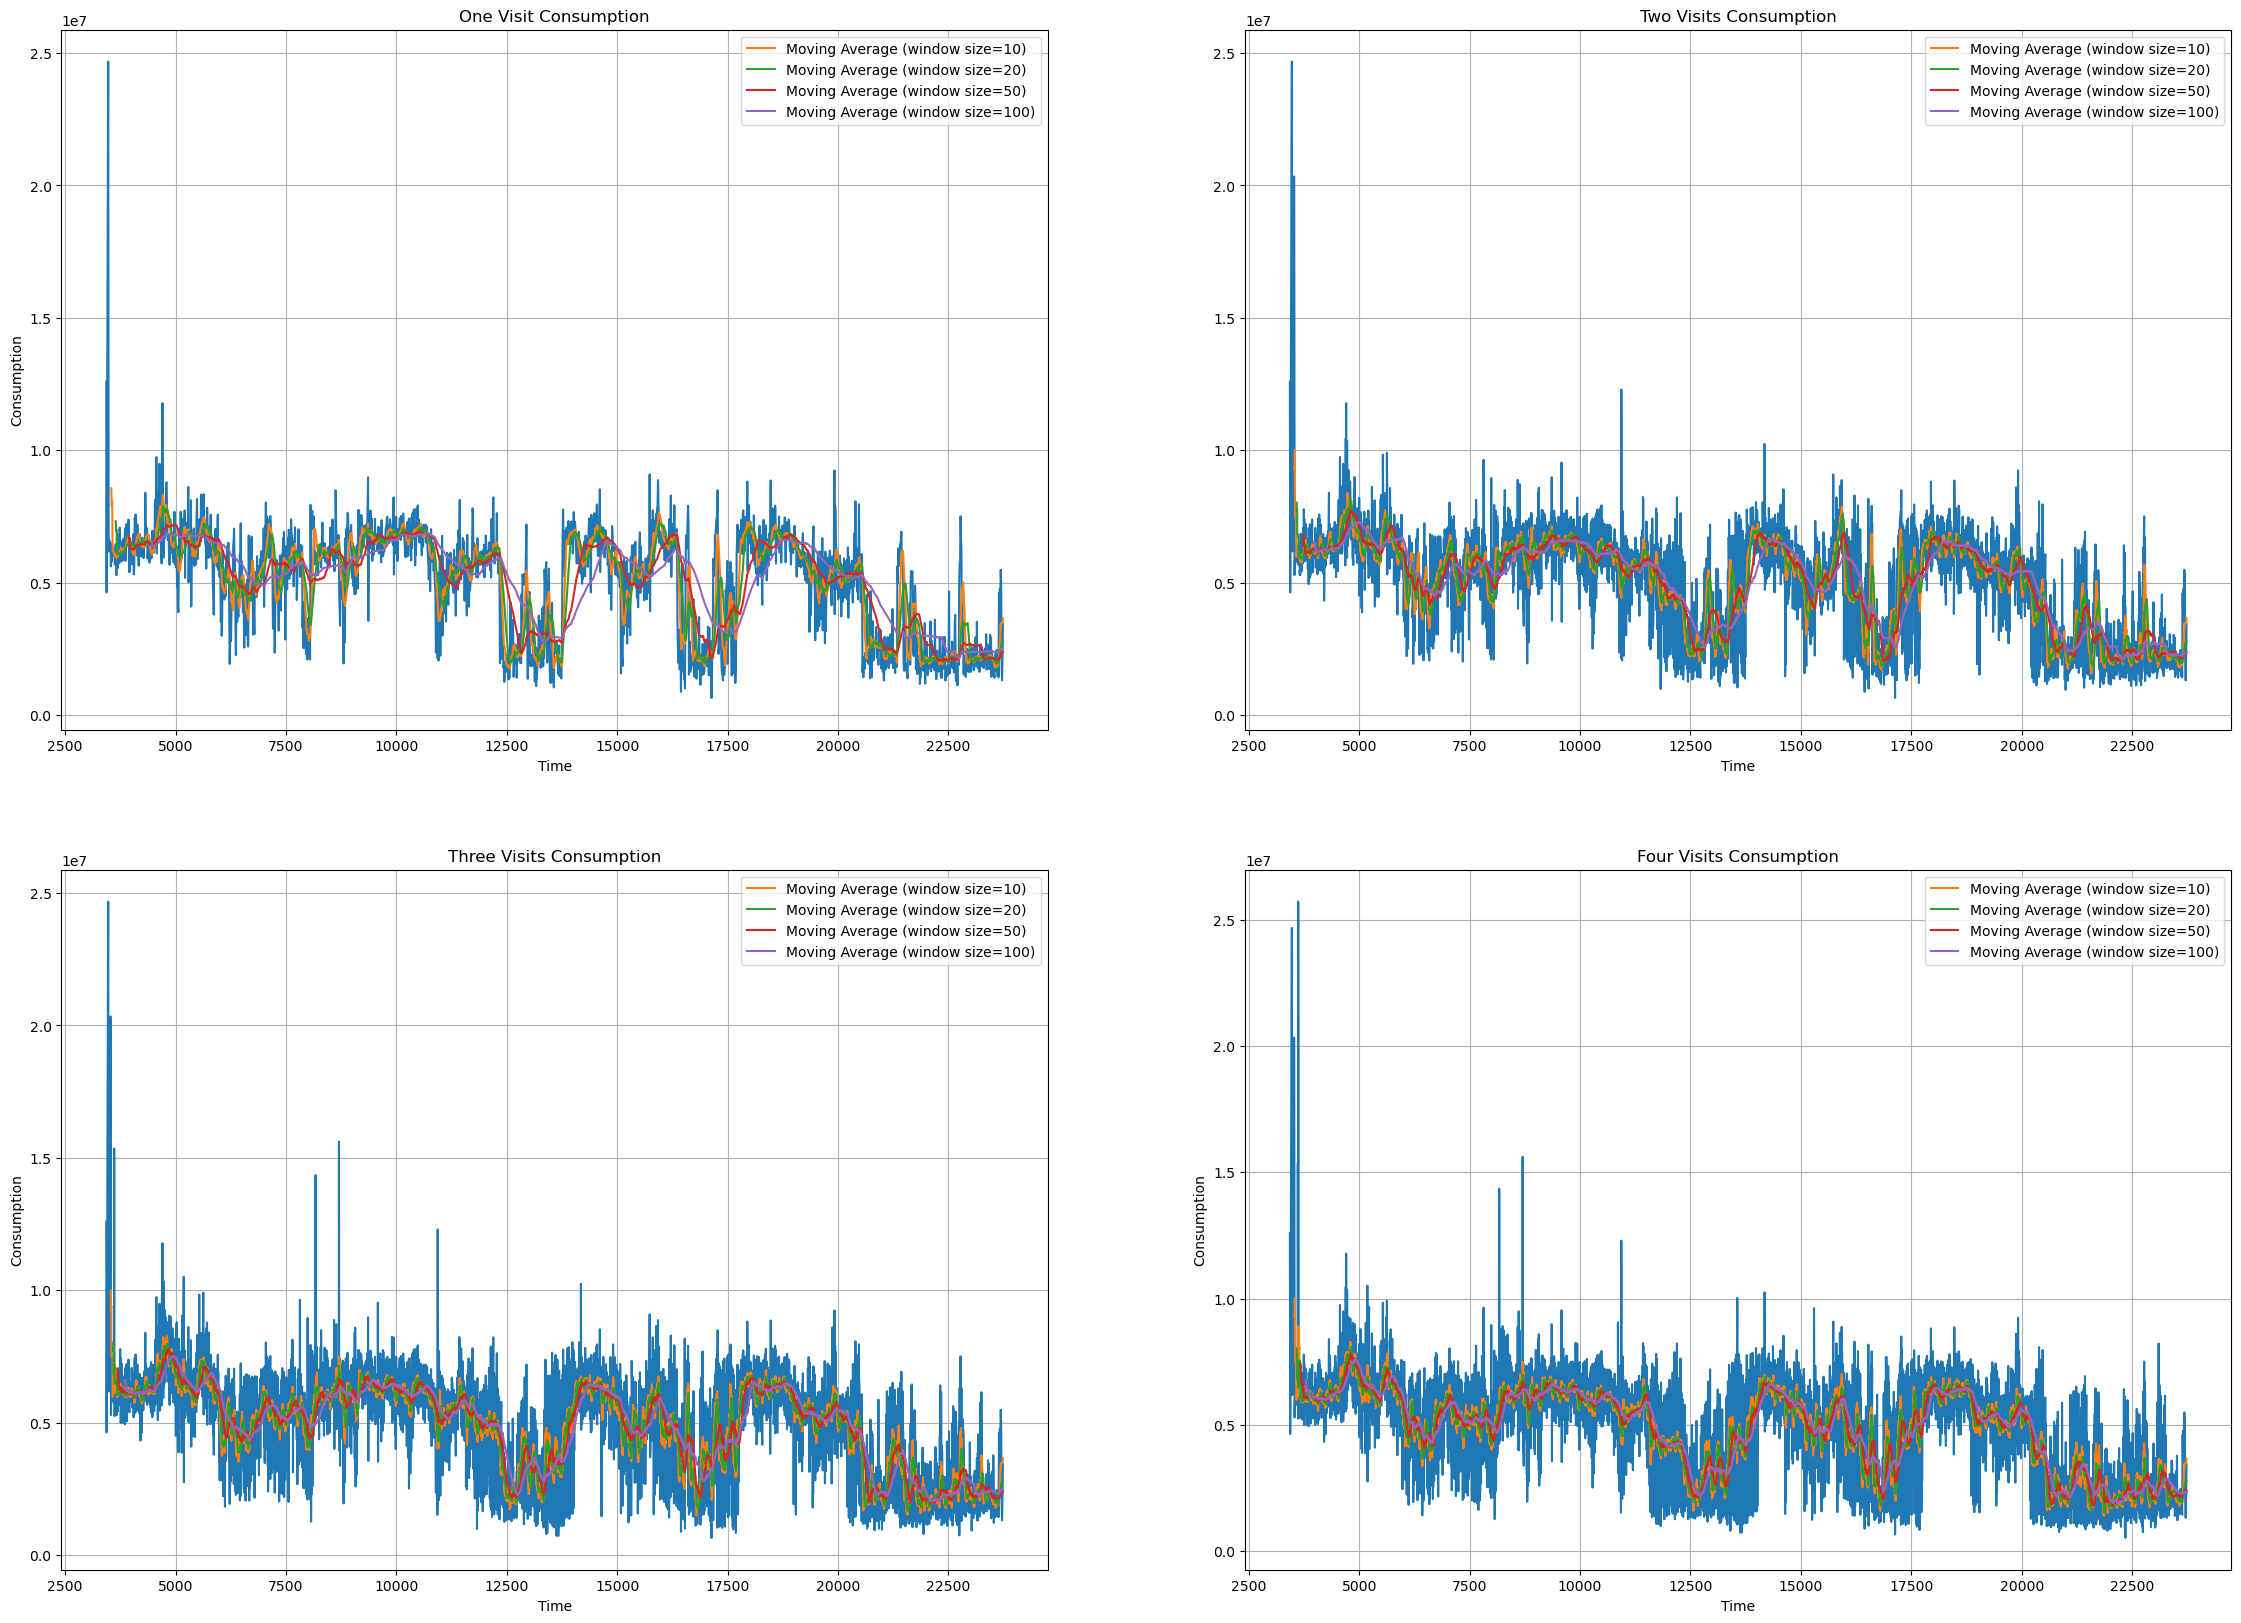

In [95]:
window_sizes = [10, 20, 50, 100]
fig, axis = plt.subplots(2,2,figsize=(28,20))
axis[0, 0].plot(dram['time'], dram['consumption'], label='')
for window_size in window_sizes:
    dram[f'consumption_ma_{window_size}'] = dram['consumption'].rolling(window=window_size).mean()
    axis[0, 0].plot(dram['time'], dram[f'consumption_ma_{window_size}'], label=f'Moving Average (window size={window_size})')
axis[0, 0].set_title("One Visit Consumption")
axis[0, 0].set_ylabel("Consumption")
axis[0, 0].set_xlabel("Time")
axis[0,0].grid()
axis[0, 0].legend()

axis[0, 1].plot(dram2['time'], dram2['consumption'], label='')
for window_size in window_sizes:
    dram2[f'consumption_ma_{window_size}'] = dram2['consumption'].rolling(window=window_size).mean()
    axis[0, 1].plot(dram2['time'], dram2[f'consumption_ma_{window_size}'], label=f'Moving Average (window size={window_size})')
axis[0, 1].set_title("Two Visits Consumption")
axis[0, 0].set_ylabel("Consumption")
axis[0, 1].set_xlabel("Time")
axis[0,1].grid()
axis[0, 1].legend()

axis[1, 0].plot(dram3['time'], dram3['consumption'], label='')
for window_size in window_sizes:
    dram3[f'consumption_ma_{window_size}'] = dram3['consumption'].rolling(window=window_size).mean()
    axis[1, 0].plot(dram3['time'], dram3[f'consumption_ma_{window_size}'], label=f'Moving Average (window size={window_size})')
axis[1, 0].set_title("Three Visits Consumption")
axis[1, 0].set_ylabel("Consumption")
axis[1, 0].set_xlabel("Time")
axis[1,0].grid()
axis[1, 0].legend()

axis[1, 1].plot(dram4['time'], dram4['consumption'], label='')
for window_size in window_sizes:
    dram4[f'consumption_ma_{window_size}'] = dram4['consumption'].rolling(window=window_size).mean()
    axis[1, 1].plot(dram4['time'], dram4[f'consumption_ma_{window_size}'], label=f'Moving Average (window size={window_size})')
axis[1, 1].set_title("Four Visits Consumption")
axis[1, 1].set_ylabel("Consumption")
axis[1, 1].set_xlabel("Time")
axis[1,1].grid()
axis[1, 1].legend()
plt.savefig('high_quality_plot.png', dpi=300)

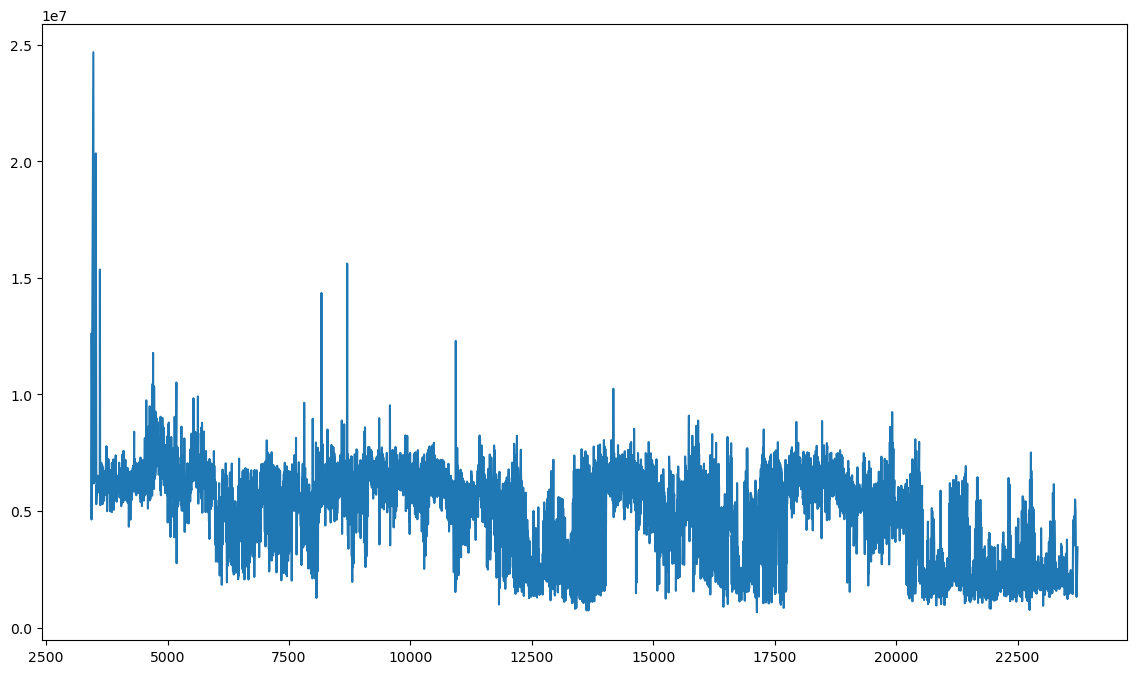

In [74]:
plt.figure(figsize=(14, 8))
plt.plot(dram3['time'], dram3['consumption'], label='')

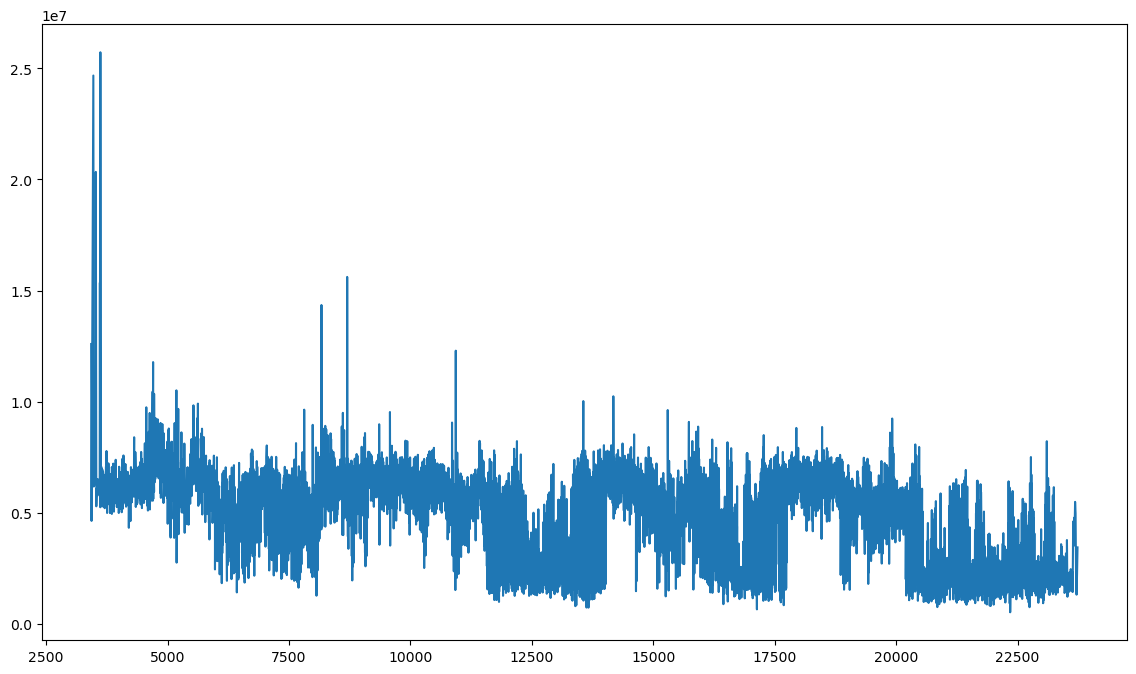

In [81]:
plt.figure(figsize=(14, 8))
plt.plot(dram4['time'], dram4['consumption'], label='')

In [6]:
import glob
from datetime import datetime


# Fonction pour lire les fichiers et extraire l'heure de téléchargement
def get_download_time(filename):
    # Extraire l'heure de téléchargement du nom de fichier (format YYYY-MM-DD HH.MM)
    basename = os.path.basename(filename)
    date_part = basename.split(' ')[1]
    time_part = basename.split(' ')[2]
    timestamp_str = date_part + ' ' + time_part.replace('.', ':')
    return datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M')

def assign_iterations(files, start_iteration):
    iterations = {}
    sorted_files = sorted(files, key=lambda x: get_download_time(x))
    current_iteration = start_iteration
    previous_time = None

    for file in sorted_files:
        current_time = get_download_time(file)
        if previous_time and current_time != previous_time:
            current_iteration += 2
        iterations[file] = current_iteration
        previous_time = current_time

    return iterations

def process_directory(directory_path):
    print("ON commence")
    # Déterminer le type de visite en fonction du nom du dossier
    if 'first' in directory_path.lower():
        start_iteration = 0
    elif 'second' in directory_path.lower():
        start_iteration = 1
    else:
        raise ValueError("Le nom du dossier doit contenir 'first' ou 'second'")

    # Lire les fichiers CSV dans le dossier
    files = glob.glob(os.path.join(directory_path, '*.csv'))
  
    

    # Assigner les itérations
    iterations = assign_iterations(files, start_iteration)

    # Ajouter la colonne itération et sauvegarder les fichiers
    for file, iteration in iterations.items():
        df = pd.read_csv(file)
        df['itération'] = iteration
        df.to_csv(file, index=False)

In [22]:
process_directory("/Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit")

ON commence
liste
['/Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/Firefox 2024-06-11 11.28 profile.json_dataframe_2.csv', '/Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/Firefox 2024-06-11 11.26 profile.json_dataframe_2.csv', '/Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/Firefox 2024-06-11 11.28 profile.json_dataframe_3.csv', '/Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/Firefox 2024-06-11 11.26 profile.json_dataframe_1.csv', '/Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/Firefox 2024-06-11 11.30 profile.json_dataframe_2.csv', '/Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/Firefox 2024-06-11 11.30 profile.json_dataframe_3.csv', '/Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/Firefox 2024-06-11 11.23 profile.json_dataframe_1.csv', '/Users/mtis/Local/Code/DataSphere/Practice/config10/second_visit/Firefox 2024-06-11 11.23 profile.json_dataframe_2.csv', '/Use

In [5]:
def concat_csv_with_keyword(root_dir, keyword, sort_column):
    # Initialisation d'une liste pour stocker les DataFrames
    data_frames = []

    # Parcours récursif des fichiers dans le dossier racine
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.csv'):
                file_path = os.path.join(dirpath, filename)
                try:
                    df = pd.read_csv(file_path)
                    # Vérification si le mot-clé est présent dans le nom du fichier
                    if keyword in filename:
                        data_frames.append(df)
                except Exception as e:
                    print(f"Erreur lors de la lecture du fichier {file_path}: {e}")

    # Concaténation de tous les DataFrames
    if data_frames:
        combined_df = pd.concat(data_frames)
        # Tri par la colonne spécifiée
        if sort_column in combined_df.columns:
            combined_df = combined_df.sort_values(by=sort_column)
            combined_df.to_csv("dataset.csv")
        else:
            print(f"La colonne '{sort_column}' n'est pas présente dans les fichiers CSV.")
            return None
        return combined_df
    else:
        print(f"Aucun fichier CSV contenant le mot-clé '{keyword}' trouvé.")
        return None


In [6]:
concat_csv_with_keyword("/Users/mtis/Local/Code/DataSphere/Practice/config10","final","time")

,time,DRAM,CPU,Iteration
0,3355.738840,11660257,169033474,11
1,3365.737305,6247627,104997423,11
2,3375.737222,6357829,104726155,11
3,3385.734049,5662706,93231202,11
4,3395.736022,6264580,104098849,11
...,...,...,...,...
22085,58262.586505,1869202,36349826,13
22086,58272.627676,1182556,34010146,13
22087,58282.589338,1636081,34400092,13
22088,58292.609367,1356337,33416748,13
